In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Pubmed

In [2]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./dataset/Pubmed', name='Pubmed')
data = dataset[0]

In [3]:
print(dataset)

Pubmed()


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

filename = 'LossAndAccuracy/GCN_Pubmed.txt'
loss_values = []
accuracy_values = []

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data)
        features = out.cpu().numpy()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    with open(filename,'a') as f: 
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

    loss_values.append(loss.item())  # Store the loss value

    accuracy_values.append(acc)  # Store the accuracy value


In [6]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7840


## precision and recall

In [7]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc


In [8]:
# Calculate precision and recall
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.7791
Recall: 0.7837


## ROC AUC 

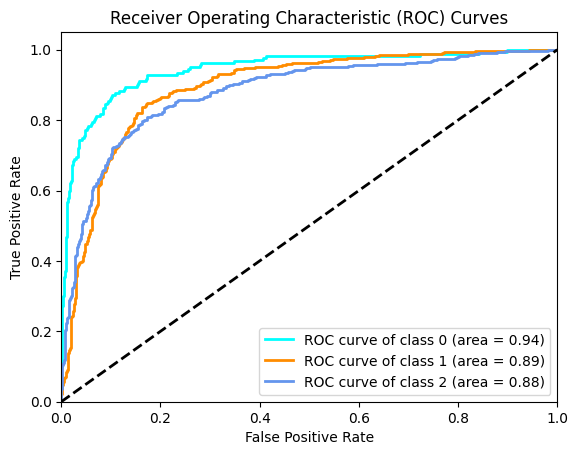

In [9]:
# Calculate ROC and AUC for each class
y_score = model(data)[data.test_mask].detach().cpu().numpy()
n_classes = dataset.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# One-hot encode the true labels
y_true_one_hot = np.eye(n_classes)[y_true]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


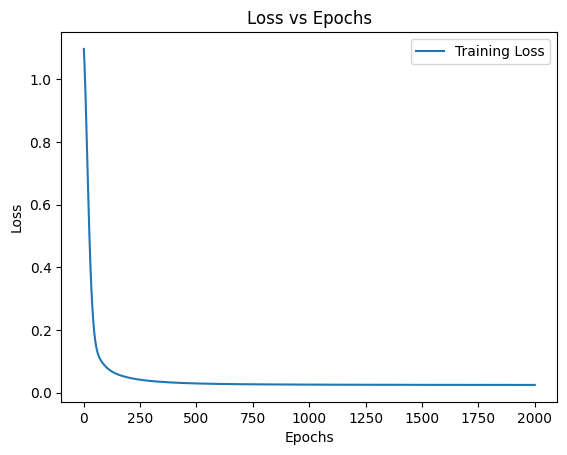

In [10]:
# Plot Loss vs Epochs
plt.plot(range(1, 2001), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

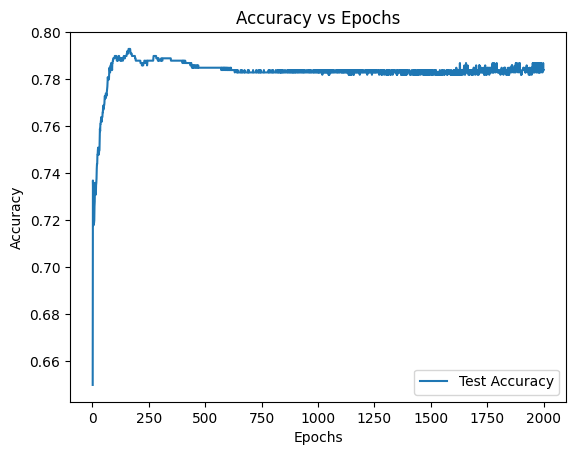

In [11]:
# Plot Accuracy vs Epochs
plt.plot(range(1, 2001), accuracy_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GCN_Pubmed.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GCN on pubmed')

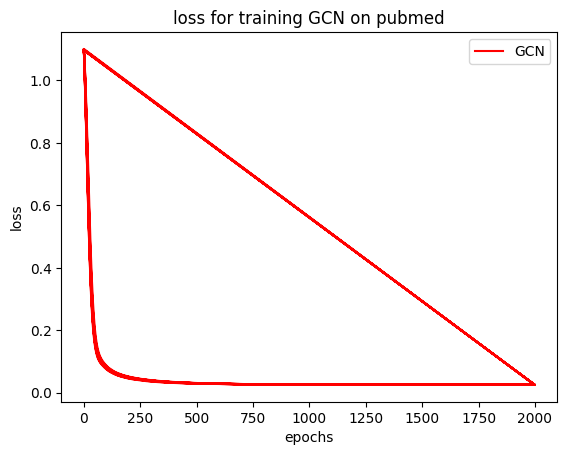

In [7]:

p2 = pl.plot(x, y1,'r-', label = u'GCN')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GCN on pubmed')

Text(0.5, 1.0, 'accuracy for training GCN on pubmed')

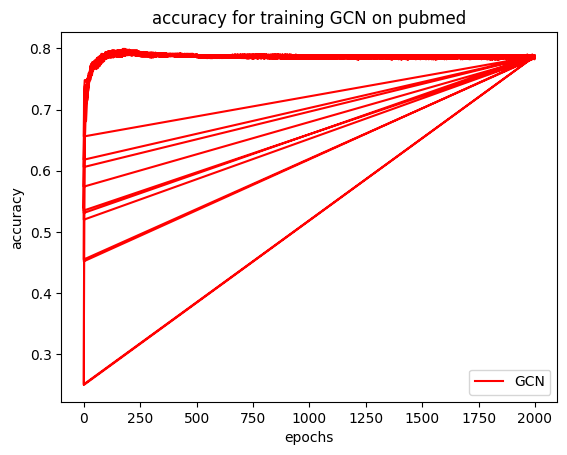

In [8]:

p2 = pl.plot(x, y2,'r-', label = u'GCN')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GCN on pubmed')

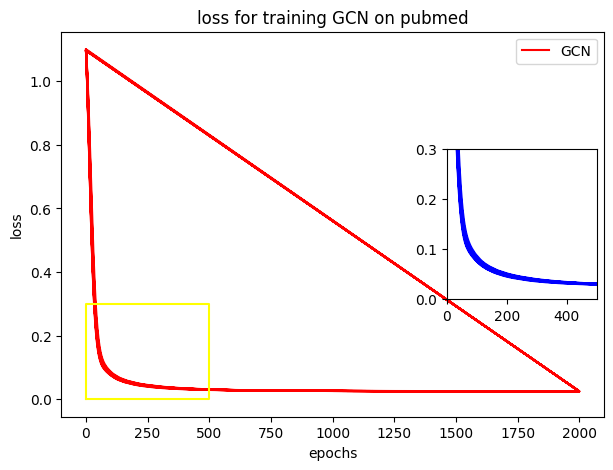

In [9]:
fig1 = plt.figure(figsize = (7,5)) 
ax1 = fig1.add_subplot(1, 1, 1)


p2 = pl.plot(x, y1,'r-', label = u'GCN')
pl.legend()
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GCN on pubmed')

tx0 = 0
tx1 = 500
ty0 = 0.000
ty1 = 0.30
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 500, 0.000, 0.30])
plt.savefig("graphs/GCN_pubmed_loss.png")
pl.show()

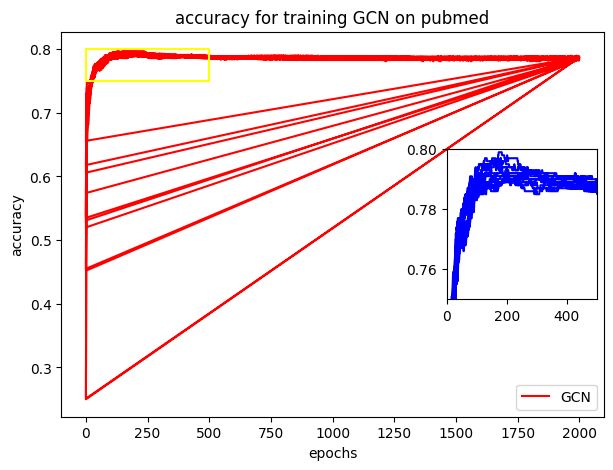

In [10]:
fig1 = plt.figure(figsize = (7,5)) 
ax1 = fig1.add_subplot(1, 1, 1) 


p2 = pl.plot(x, y2,'r-', label = u'GCN')
pl.legend()
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GCN on pubmed')

tx0 = 0
tx1 = 500
ty0 = 0.75
ty1 = 0.80
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 500, 0.75, 0.80])
plt.savefig("graphs/GCN_pubmed_accuracy.png")
pl.show()

K-Means clustering

In [11]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

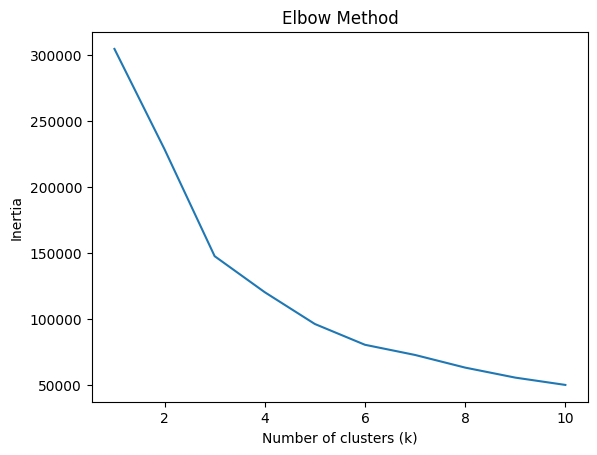

In [12]:
# Elbow method to find optimal k
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [13]:
# Choose the optimal k (elbow point)
optimal_k = 3  # Adjust based on the elbow plot

# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(features)
labels = kmeans.labels_

In [14]:
adjusted_rand_index = adjusted_rand_score(data.y.numpy(), labels)
normalized_mutual_info = normalized_mutual_info_score(data.y.numpy(), labels)

In [15]:
print("Adjusted Rand Index:", adjusted_rand_index)
print("Normalized Mutual Information:", normalized_mutual_info)

Adjusted Rand Index: 0.2756469500170453
Normalized Mutual Information: 0.3120930198878033


In [16]:
import math
from scipy.sparse import coo_matrix
from scipy.sparse import diags

In [17]:
total_entropy = 0
for cluster_label in range(optimal_k):
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_size = len(cluster_indices)
    if cluster_size == 0:
        continue
    cluster_probability = cluster_size / len(labels)
    cluster_entropy = -cluster_probability * math.log(cluster_probability)
    total_entropy += cluster_entropy

print("Entropy:", total_entropy)

Entropy: 0.9191798823092385


In [18]:
centroids = kmeans.cluster_centers_
total_data_points = len(features)
total_volume = 0
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    if len(cluster_indices) == 0:
        continue
    avg_distance = np.mean(np.linalg.norm(features[cluster_indices] - centroids[i], axis=1))
    volume = len(cluster_indices) * avg_distance
    total_volume += volume

overall_density = total_data_points / total_volume

print("Density:", overall_density)

Density: 0.44266180063806865


In [19]:
# Construct adjacency matrix
adjacency = coo_matrix((np.ones(len(data.edge_index[0])), (data.edge_index[0], data.edge_index[1])),
                       shape=(len(data.x), len(data.x)))

# Compute modularity
modularity = 0
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    cluster_adjacency = adjacency.tocsr()[cluster_indices, :][:, cluster_indices]
    cluster_degree = np.sum(cluster_adjacency)
    cluster_internal_degree = np.sum(cluster_adjacency.diagonal())
    modularity += (cluster_internal_degree / (2 * len(data.edge_index[0])) - 
                   (cluster_degree / (2 * len(data.edge_index[0]))) ** 2)

print("Modularity:", modularity)

Modularity: -0.0484253850303694


In [20]:
total_boundary_edges = 0
total_cluster_volume = 0

for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    cluster_adjacency = adjacency.tocsr()[cluster_indices, :]
    cluster_volume = np.sum(cluster_adjacency)
    total_cluster_volume += cluster_volume

    if cluster_volume != 0:
        diagonal = cluster_adjacency.diagonal()
        diagonal_matrix = diags(diagonal, offsets=0, shape=cluster_adjacency.shape, format='csr')
        cluster_boundary = cluster_adjacency - diagonal_matrix
        boundary_edges = cluster_boundary.sum()
        total_boundary_edges += boundary_edges

overall_conductance = total_boundary_edges / total_cluster_volume
print("Conductance:", overall_conductance)

Conductance: 0.9999661582889631


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [25]:
# Apply PCA to reduce feature space to 2 dimensions
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

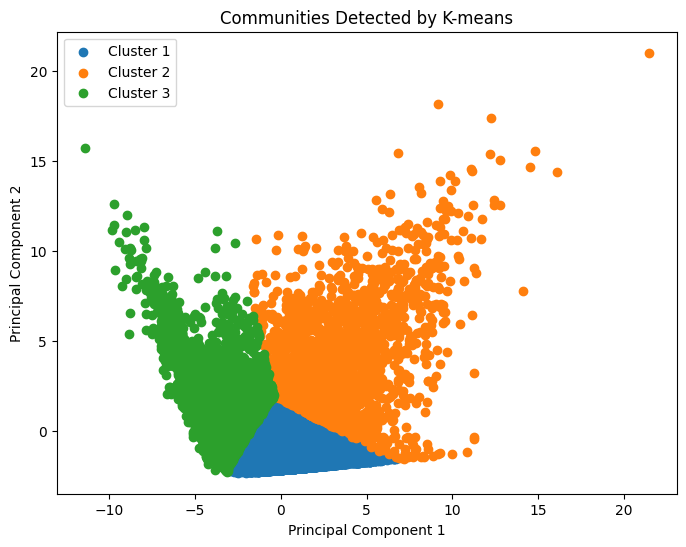

In [26]:
# Plot communities
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    plt.scatter(features_2d[labels == i, 0], features_2d[labels == i, 1], label=f'Cluster {i+1}')
plt.title('Communities Detected by K-means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Spectral clustering


In [27]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

Silhouette scores

Optimal number of clusters: 3


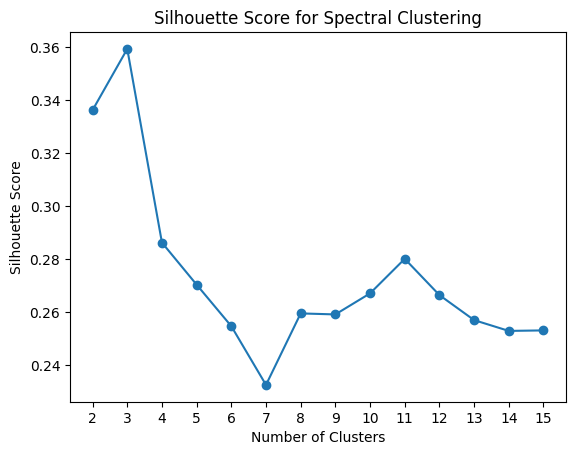

In [28]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

# Initialize a range of cluster numbers to try
min_clusters = 2
max_clusters = 15
range_n_clusters = range(min_clusters, max_clusters + 1)

# Apply PCA to reduce feature space for spectral clustering
n_components = min(10, features.shape[1])  # Adjust based on feature dimensions
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features)

# Evaluate silhouette scores for different number of clusters
silhouette_scores = []
for n_clusters in range_n_clusters:
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
    labels = spectral_clustering.fit_predict(features_pca)
    silhouette_avg = silhouette_score(features_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters with the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_n_clusters)

# Plot silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score for Spectral Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.show()


In [29]:
# Apply Spectral Clustering
n_clusters = 3  # Adjust based on your dataset
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
labels = spectral_clustering.fit_predict(features)

In [30]:
# Calculate Adjusted Rand Index and Normalized Mutual Information
adjusted_rand_index = adjusted_rand_score(data.y.numpy(), labels)
normalized_mutual_info = normalized_mutual_info_score(data.y.numpy(), labels)

In [31]:

print("Adjusted Rand Index:", adjusted_rand_index)
print("Normalized Mutual Information:", normalized_mutual_info)

Adjusted Rand Index: 0.39349119715907105
Normalized Mutual Information: 0.3608946709673942


In [32]:
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix

In [33]:
# Calculate Entropy
def entropy(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    probs = counts / len(labels)
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

# Calculate Density
def density(labels, adjacency_matrix):
    num_clusters = len(np.unique(labels))
    density_sum = 0
    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_density = np.sum(adjacency_matrix[cluster_indices][:, cluster_indices]) / len(cluster_indices)
        density_sum += cluster_density
    density = density_sum / num_clusters
    return density

# Calculate Modularity
def modularity(labels, adjacency_matrix):
    num_clusters = len(np.unique(labels))
    modularity = 0
    total_weight = np.sum(adjacency_matrix)
    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_subgraph = adjacency_matrix[cluster_indices][:, cluster_indices]
        intra_cluster_weight = np.sum(cluster_subgraph)
        expected_weight = (np.sum(adjacency_matrix[cluster_indices], axis=0) * np.sum(adjacency_matrix[:, cluster_indices], axis=1)) / total_weight
        modularity += (intra_cluster_weight - expected_weight.sum()) / total_weight
    return modularity

# Calculate Conductance
def conductance(labels, adjacency_matrix):
    num_clusters = len(np.unique(labels))
    conductance_sum = 0
    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_subgraph = adjacency_matrix[cluster_indices][:, cluster_indices]
        cluster_degree = np.sum(cluster_subgraph, axis=1)
        cluster_edges = np.sum(cluster_degree) / 2
        if cluster_edges == 0:
            continue
        cut_edges = np.sum(cluster_degree) - np.sum(np.diag(cluster_subgraph.toarray()))
        conductance = cut_edges / cluster_edges
        conductance_sum += conductance
    conductance_avg = conductance_sum / num_clusters
    return conductance_avg

# Assuming features is your feature matrix and adjacency_matrix is your adjacency matrix
# You can compute adjacency matrix using kneighbors_graph or any other appropriate method
# For example, if features is a torch tensor, you can convert it to numpy array using features.numpy()

# Compute adjacency matrix
adjacency_matrix = kneighbors_graph(features, n_neighbors=10, mode='connectivity')
adjacency_matrix = csr_matrix(adjacency_matrix)

# Calculate metrics
entropy_value = entropy(labels)
density_value = density(labels, adjacency_matrix)
modularity_value = modularity(labels, adjacency_matrix)
conductance_value = conductance(labels, adjacency_matrix)

print("Entropy:", entropy_value)
print("Density:", density_value)
print("Modularity:", modularity_value)
print("Conductance:", conductance_value)


Entropy: 1.5354981287587361
Density: 9.92196045153972
Modularity: 0.9924384916220141
Conductance: 2.0


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [25]:
# Apply PCA to reduce feature space to 2 dimensions
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

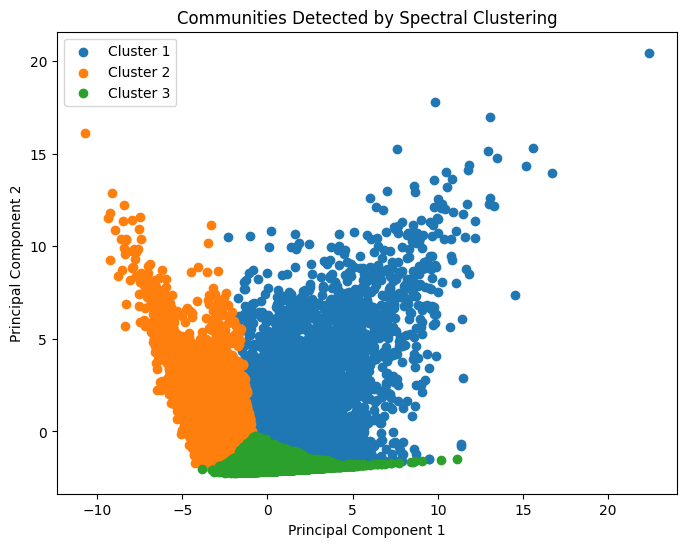

In [26]:
# Plot communities
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(features_2d[labels == i, 0], features_2d[labels == i, 1], label=f'Cluster {i+1}')
plt.title('Communities Detected by Spectral Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Louvain algorithm

In [27]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import networkx as nx
import community  # Louvain algorithm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Create a networkx graph
G = nx.Graph()
G.add_nodes_from(range(len(features)))

In [29]:
# Add edges based on the connectivity in the dataset
edge_index = data.edge_index.cpu().numpy()
for i in range(edge_index.shape[1]):
    src, dst = edge_index[0][i], edge_index[1][i]
    G.add_edge(src, dst)


In [30]:
# Apply Louvain algorithm for community detection
partition = community.best_partition(G)

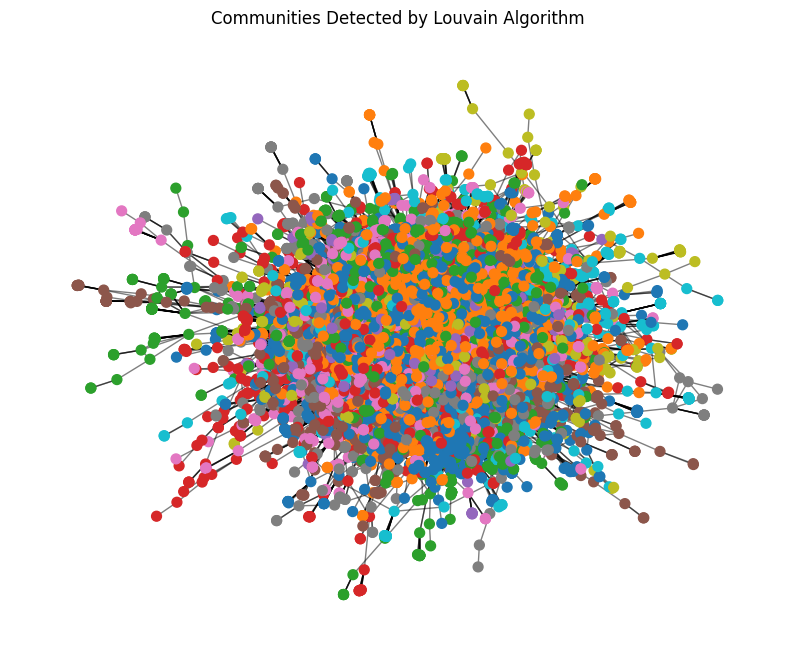

In [31]:
# Visualize communities
pos = nx.spring_layout(G)  # Layout algorithm for visualization
plt.figure(figsize=(10, 8))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.get_cmap('tab10'), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Communities Detected by Louvain Algorithm')
plt.show()

In [32]:
# Calculate Adjusted Rand Index and Normalized Mutual Information
# For comparison, we'll use the ground truth labels from the dataset
ground_truth_labels = data.y.numpy()
louvain_labels = np.array([partition[i] for i in range(len(G))])

adjusted_rand_index = adjusted_rand_score(ground_truth_labels, louvain_labels)
normalized_mutual_info = normalized_mutual_info_score(ground_truth_labels, louvain_labels)

print("Adjusted Rand Index (ARI) for Louvain Algorithm:", adjusted_rand_index)
print("Normalized Mutual Information (NMI) for Louvain Algorithm:", normalized_mutual_info)

Adjusted Rand Index (ARI) for Louvain Algorithm: 0.09461306125378366
Normalized Mutual Information (NMI) for Louvain Algorithm: 0.20003413629408934


In [33]:
import numpy as np
from collections import Counter

In [34]:
def entropy(partition):
    values = np.array(list(partition.values()))
    counts = np.bincount(values)
    probs = counts / len(values)
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

def density(partition, G):
    num_edges_internal = 0
    num_nodes_internal = 0
    for node, community in partition.items():
        num_edges_internal += len([neighbor for neighbor in G.neighbors(node) if partition[neighbor] == community])
        num_nodes_internal += 1
    num_communities = len(set(partition.values()))
    if num_nodes_internal == 0 or num_communities == 0:
        return 0
    else:
        return num_edges_internal / (num_nodes_internal * num_communities)

def modularity(partition, G):
    num_edges = G.number_of_edges()
    num_communities = len(set(partition.values()))
    if num_communities == 0:
        return 0
    modularity = 0
    for community in set(partition.values()):
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        subgraph = G.subgraph(nodes_in_community)
        num_edges_internal = subgraph.number_of_edges()
        num_nodes = subgraph.number_of_nodes()
        num_edges_external = num_edges - num_edges_internal
        modularity += (num_edges_internal / num_edges) - ((num_nodes / (2 * num_edges)) ** 2)
    return modularity

def conductance(partition, G):
    conductances = []
    for community in set(partition.values()):
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        num_edges_internal = 0
        num_cut_edges = 0
        for node in nodes_in_community:
            neighbors = set(G.neighbors(node))
            num_edges_internal += len(neighbors.intersection(nodes_in_community))
            num_cut_edges += len(neighbors.difference(nodes_in_community))
        if num_edges_internal == 0 or (num_edges_internal + num_cut_edges) == 0:
            conductance = 0
        else:
            conductance = num_cut_edges / (num_edges_internal + num_cut_edges)
        conductances.append(conductance)
    return np.mean(conductances)

# Calculate metrics
entropy_value = entropy(partition)
density_value = density(partition, G)
modularity_value = modularity(partition, G)
conductance_value = conductance(partition, G)

print("Entropy:", entropy_value)
print("Density:", density_value)
print("Modularity:", modularity_value)
print("Conductance:", conductance_value)

Entropy: 4.4367066766531105
Density: 0.0980957471295758
Modularity: 0.8480468333538416
Conductance: 0.1394069733793925


Model's Details

In [35]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.bias 	 torch.Size([16])
conv1.lin.weight 	 torch.Size([16, 500])
conv2.bias 	 torch.Size([3])
conv2.lin.weight 	 torch.Size([3, 16])
Optimizer's state_dict:
state 	 {0: {'step': tensor(2000.), 'exp_avg': tensor([ 6.4318e-05, -8.7176e-05,  4.8570e-05,  4.1188e-05,  1.3234e-04,
        -2.1824e-05, -6.7797e-05, -9.2310e-05, -4.9792e-08, -9.9873e-05,
         1.8970e-05,  4.1908e-05, -2.3944e-06,  7.5707e-05, -1.0681e-04,
         7.1543e-05]), 'exp_avg_sq': tensor([2.1281e-06, 4.5387e-07, 1.0317e-06, 8.8949e-07, 2.8333e-06, 6.2376e-07,
        5.0604e-07, 4.8464e-07, 6.1107e-07, 6.7841e-07, 4.3821e-07, 1.1532e-06,
        3.7196e-08, 1.4583e-06, 9.1848e-07, 1.0847e-06])}, 1: {'step': tensor(2000.), 'exp_avg': tensor([[-3.1758e-06,  1.5697e-07,  3.5634e-07,  ...,  3.7550e-07,
          3.0066e-08,  1.1080e-07],
        [-1.5031e-06, -2.7089e-07, -8.4229e-07,  ..., -6.0213e-07,
         -5.4948e-07, -3.6709e-07],
        [ 8.5133e-07,  1.9775e-08,  4.1041e-07,  ..

In [36]:
torch.save(model.state_dict(),'GCNpubmed.pkl')